In [1]:
# Basic Packages
import pandas as pd
import numpy as np
from functools import reduce
from datetime import datetime as dt

# Visualizations
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

# Modeling
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
df = pd.read_csv("../API Data Out/schedule_2018_to_2023.csv", index_col=0)

In [3]:
df.insert(6, "score_diff", df.home_score - df.away_score)

In [4]:
df.sort_values(by=['game_id'], ascending = False, inplace=True)
df.columns

Index(['game_id', 'season', 'game_type', 'week', 'gameday', 'weekday',
       'score_diff', 'gametime', 'away_team', 'away_score', 'home_team',
       'home_score', 'location', 'result', 'total', 'overtime', 'old_game_id',
       'gsis', 'nfl_detail_id', 'pfr', 'pff', 'espn', 'ftn', 'away_rest',
       'home_rest', 'away_moneyline', 'home_moneyline', 'spread_line',
       'away_spread_odds', 'home_spread_odds', 'total_line', 'under_odds',
       'over_odds', 'div_game', 'roof', 'surface', 'temp', 'wind',
       'away_qb_id', 'home_qb_id', 'away_qb_name', 'home_qb_name',
       'away_coach', 'home_coach', 'referee', 'stadium_id', 'stadium'],
      dtype='object')

In [5]:
df = df.loc[:, ('game_id', 'game_type', 'weekday', 'score_diff', 'spread_line', 'total_line')]
df.dropna(inplace=True)
df

,game_id,game_type,weekday,score_diff,spread_line,total_line
6501,2023_06_WAS_ATL,REG,Sunday,-8.0,1.5,42.0
6504,2023_06_SF_CLE,REG,Sunday,2.0,-9.5,36.0
6503,2023_06_SEA_CIN,REG,Sunday,4.0,3.0,45.5
6510,2023_06_PHI_NYJ,REG,Sunday,6.0,-6.5,43.0
6512,2023_06_NYG_BUF,REG,Sunday,5.0,15.5,43.5
...,...,...,...,...,...,...
5060,2018_01_DAL_CAR,REG,Sunday,8.0,2.5,42.5
5052,2018_01_CIN_IND,REG,Sunday,-11.0,-1.0,47.5
5062,2018_01_CHI_GB,REG,Sunday,1.0,6.5,45.0
5050,2018_01_BUF_BAL,REG,Sunday,44.0,7.5,39.0


In [6]:
# Adding in columns we'll need later before we filter
teaser_points = 6
df['teased_line'] = np.where(((abs(df.loc[:, 'spread_line']) < 3) & (df.loc[:, 'spread_line'] > 0)) | ((abs(df.loc[:, 'spread_line']) > 3) & (df.loc[:, 'spread_line'] < 0)),
                             df.loc[:, 'spread_line'] + 6, df.loc[:, 'spread_line'] - 6)
df['home_favorite'] = np.where(df.loc[:, 'spread_line'] > 0, 1, 0)
df['home_cover'] = np.where(df.loc[:, 'score_diff'] > df.loc[:, 'spread_line'], 1, 0)
df['home_win'] = np.where(df.loc[:, 'score_diff'] > 0, 1, 0)
df['home_tease_opp'] = np.where(((df.loc[:, 'spread_line'] < 0) & (abs(df.loc[:, 'spread_line']) < 3)) | ((df.loc[:, 'spread_line'] > 0) & (abs(df.loc[:, 'spread_line']) > 3)) , 1, 0)
df['fav_tease_opp'] = np.where(abs(df.loc[:, 'spread_line']) > 3, 1, 0)
df['home_dog_cover_tease'] = np.where((df.loc[:, 'score_diff'] > df.loc[:, 'teased_line']) & (abs(df.loc[:, 'teased_line']) > 3) & ((df.loc[:, 'teased_line']) < 0), 1, 0)
df['away_fav_cover_tease'] = np.where((df.loc[:, 'score_diff'] < df.loc[:, 'teased_line']) & (abs(df.loc[:, 'teased_line']) < 3) & ((df.loc[:, 'teased_line']) < 0), 1, 0)
df['away_dog_cover_tease'] = np.where((df.loc[:, 'score_diff'] < df.loc[:, 'teased_line']) & (abs(df.loc[:, 'teased_line']) > 3) & ((df.loc[:, 'teased_line']) > 0), 1, 0)
df['home_fav_cover_tease'] = np.where((df.loc[:, 'score_diff'] > df.loc[:, 'teased_line']) & (abs(df.loc[:, 'teased_line']) < 3) & ((df.loc[:, 'teased_line']) > 0), 1, 0)
df['total_tease_covers'] = df.loc[:, 'home_dog_cover_tease'] + df.loc[:, 'away_fav_cover_tease'] + df.loc[:, 'away_dog_cover_tease'] + df.loc[:, 'home_fav_cover_tease'] 

In [7]:
# Limiting to only games in our sweet spot range
total_cutoff = 51
favs = (abs(df.spread_line) >= 7.5) & (abs(df.spread_line) <= 8.5)
dogs = (abs(df.spread_line) >= 1.5) & (abs(df.spread_line) <= 2.5)
df = df.loc[(favs | dogs) & (df.score_diff != 0) & (df.total_line <= total_cutoff)]
df.head(50)

,game_id,game_type,weekday,score_diff,spread_line,total_line,teased_line,home_favorite,home_cover,home_win,home_tease_opp,fav_tease_opp,home_dog_cover_tease,away_fav_cover_tease,away_dog_cover_tease,home_fav_cover_tease,total_tease_covers
6501,2023_06_WAS_ATL,REG,Sunday,-8.0,1.5,42.0,7.5,1,0,0,0,0,0,0,1,0,1
6505,2023_06_NO_HOU,REG,Sunday,7.0,-2.0,42.5,-8.0,0,1,1,1,0,1,0,0,0,1
6513,2023_06_DAL_LAC,REG,Monday,-3.0,-1.5,49.5,-7.5,0,0,0,1,0,1,0,0,0,1
6489,2023_05_TEN_IND,REG,Sunday,7.0,-2.5,43.5,-8.5,0,1,1,1,0,1,0,0,0,1
6495,2023_05_NYJ_DEN,REG,Sunday,-10.0,2.5,42.5,8.5,1,0,0,0,0,0,0,1,0,1
6491,2023_05_NO_NE,REG,Sunday,-34.0,2.5,38.5,8.5,1,0,0,0,0,0,0,1,0,1
6487,2023_05_HOU_ATL,REG,Sunday,2.0,2.5,42.0,8.5,1,0,1,0,0,0,0,1,0,1
6484,2023_04_SEA_NYG,REG,Monday,-21.0,-2.5,46.5,-8.5,0,0,0,1,0,0,0,0,0,0
6469,2023_04_DET_GB,REG,Thursday,-14.0,-2.5,45.0,-8.5,0,0,0,1,0,0,0,0,0,0
6479,2023_04_CIN_TEN,REG,Sunday,24.0,-2.5,41.5,-8.5,0,1,1,1,0,1,0,0,0,1


In [8]:
tease_opportunities = len(df)
dog_tease_opportunities = len(df[abs(df.teased_line) > 3])
fav_tease_opportunities = len(df[abs(df.teased_line) < 3])
home_tease_opportunities = len(df[df.home_tease_opp == 1])
away_tease_opportunities = len(df[df.home_tease_opp == 0])

In [9]:
home_dog_cover_tease = len(df[df.home_dog_cover_tease ==1])
away_fav_cover_tease = len(df[df.away_fav_cover_tease ==1])
away_dog_cover_tease = len(df[df.away_dog_cover_tease ==1])
home_fav_cover_tease = len(df[df.home_fav_cover_tease ==1])
total_tease_covers = len(df[df.total_tease_covers ==1])
home_tease_covers = home_dog_cover_tease + home_fav_cover_tease
away_tease_covers = away_fav_cover_tease + away_dog_cover_tease
fav_tease_covers = home_fav_cover_tease + away_fav_cover_tease
dog_tease_covers = home_dog_cover_tease + away_dog_cover_tease

In [10]:
print(f"There are {dog_tease_opportunities} dog tease opps")
print(f"There are {fav_tease_opportunities} fav tease opps")
print(f"There are {home_tease_opportunities} home tease opps")
print(f"There are {away_tease_opportunities} away tease opps")
print(f"There are {tease_opportunities} total opps")

There are 166 dog tease opps
There are 109 fav tease opps
There are 156 home tease opps
There are 119 away tease opps
There are 275 total opps


In [11]:
print("A tease opportunity is when a favorite is favored between 7.5 - 8.5 OR an underdog is getting 1.5 - 2.5 points. This is because you can tease through the 2 key numbers, 3 & 7")
print(f"There were {tease_opportunities} tease opportunities available")
print(f"{total_tease_covers} of those opportunities hit. This is a {total_tease_covers/tease_opportunities*100:.2f}% rate overall")
print(f"{home_tease_covers} of those covers were at home ({home_tease_covers/home_tease_opportunities*100:.2f}%) and {away_tease_covers} were on the road ({away_tease_covers/away_tease_opportunities*100:.2f}%)")
print(f"{fav_tease_covers} of those covers were favorites ({fav_tease_covers/fav_tease_opportunities*100:.2f}%)  and {dog_tease_covers} were underdogs ({dog_tease_covers/dog_tease_opportunities*100:.2f}%)")

A tease opportunity is when a favorite is favored between 7.5 - 8.5 OR an underdog is getting 1.5 - 2.5 points. This is because you can tease through the 2 key numbers, 3 & 7
There were 275 tease opportunities available
207 of those opportunities hit. This is a 75.27% rate overall
113 of those covers were at home (72.44%) and 94 were on the road (78.99%)
79 of those covers were favorites (72.48%)  and 128 were underdogs (77.11%)


In [12]:
# Lets see how the percentages change as you reduce the over and under. As you bring it down, the tease should hit more often
# I ran these. Under 47 points went up to 84% and under 42 points went all the way to 85%

In [13]:
# Lets see if this is profitable if you play every possible teaser, even considering the juice

In [14]:
# Constants
bet = 100
two_team_teaser_win = 0.8333
three_team_teaser_win = 1.6

In [15]:
# 2 team teaser

leg_number = 2
leg_hit_prob = total_tease_covers/tease_opportunities
teaser_hit_chance = leg_hit_prob ** leg_number
expected_value = teaser_hit_chance * (bet *two_team_teaser_win) - (1 - teaser_hit_chance) * bet

print(f"{leg_number} team teaser - All opportunties")
print(f"Leg hit chance: %{leg_hit_prob *100:.2f}")
print(f"Teaser hit chance: %{teaser_hit_chance *100:.2f}")
print(f"The expected value of a ${bet} bet: ${expected_value:.2f} profit")

2 team teaser - All opportunties
Leg hit chance: %75.27
Teaser hit chance: %56.66
The expected value of a $100 bet: $3.87 profit


In [16]:
# Checking 3 team teasers

leg_number = 3
leg_hit_prob = total_tease_covers/tease_opportunities
teaser_hit_chance = leg_hit_prob ** leg_number
expected_value = teaser_hit_chance * (bet *three_team_teaser_win) - (1 - teaser_hit_chance) * bet

print(f"{leg_number} team teaser - All opportunties")
print(f"Leg hit chance: %{leg_hit_prob *100:.2f}")
print(f"Teaser hit chance: %{teaser_hit_chance *100:.2f}")
print(f"The expected value of a ${bet} bet: ${expected_value:.2f} profit")

3 team teaser - All opportunties
Leg hit chance: %75.27
Teaser hit chance: %42.65
The expected value of a $100 bet: $10.89 profit


In [17]:
# What about just underdogs

leg_number = 2
leg_hit_prob = dog_tease_covers/dog_tease_opportunities
teaser_hit_chance = leg_hit_prob ** leg_number
expected_value = teaser_hit_chance * (bet * two_team_teaser_win) - (1 - teaser_hit_chance) * bet

print(f"{leg_number} team teaser - Underdogs Only")
print(f"Leg hit chance: %{leg_hit_prob *100:.2f}")
print(f"Teaser hit chance: %{teaser_hit_chance *100:.2f}")
print(f"The expected value of a ${bet} bet is ${expected_value:.2f} profit")

2 team teaser - Underdogs Only
Leg hit chance: %77.11
Teaser hit chance: %59.46
The expected value of a $100 bet is $9.00 profit


In [18]:
# What about just favorites

leg_number = 2
leg_hit_prob = fav_tease_covers/fav_tease_opportunities
teaser_hit_chance = leg_hit_prob ** leg_number
expected_value = teaser_hit_chance * (bet *two_team_teaser_win) - (1 - teaser_hit_chance) * bet

print(f"{leg_number} team teaser - Favorites Only")
print(f"Leg hit chance: %{leg_hit_prob *100:.2f}")
print(f"Teaser hit chance: %{teaser_hit_chance *100:.2f}")
print(f"The expected value of a ${bet} bet is ${expected_value:.2f} profit")

2 team teaser - Favorites Only
Leg hit chance: %72.48
Teaser hit chance: %52.53
The expected value of a $100 bet is $-3.70 profit


In [19]:
# What about only home teams?

leg_number = 2
leg_hit_prob = home_tease_covers/home_tease_opportunities
teaser_hit_chance = leg_hit_prob ** leg_number
expected_value = teaser_hit_chance * (bet *two_team_teaser_win) - (1 - teaser_hit_chance) * bet

print(f"{leg_number} team teaser - Home Only")
print(f"Leg hit chance: %{leg_hit_prob *100:.2f}")
print(f"Teaser hit chance: %{teaser_hit_chance *100:.2f}")
print(f"The expected value of a ${bet} bet is ${expected_value:.2f} profit")

2 team teaser - Home Only
Leg hit chance: %72.44
Teaser hit chance: %52.47
The expected value of a $100 bet is $-3.81 profit


In [20]:
# What about only away teams?

leg_number = 2
leg_hit_prob = away_tease_covers/away_tease_opportunities
teaser_hit_chance = leg_hit_prob ** leg_number
expected_value = teaser_hit_chance * (bet *two_team_teaser_win) - (1 - teaser_hit_chance) * bet

print(f"{leg_number} team teaser - Away Only")
print(f"Leg hit chance: %{leg_hit_prob *100:.2f}")
print(f"Teaser hit chance: %{teaser_hit_chance *100:.2f}")
print(f"The expected value of a ${bet} bet is ${expected_value:.2f} profit")

2 team teaser - Away Only
Leg hit chance: %78.99
Teaser hit chance: %62.40
The expected value of a $100 bet is $14.39 profit


In [21]:
# Lets group and look at EV by spread
grouped = df[['score_diff', 'total_tease_covers' ]].groupby(df.spread_line).mean()
grouped['EV'] = grouped.loc[:, 'total_tease_covers'] * (bet *two_team_teaser_win) - (1 - teaser_hit_chance) * bet
grouped = grouped[(grouped.total_tease_covers != 1) & (grouped.total_tease_covers != 0)]
grouped

,score_diff,total_tease_covers,EV
spread_line,,,
-8.5,-0.200000,0.600000,12.394723
-7.5,-6.285714,0.761905,25.886247
-2.5,-1.627907,0.674419,18.596026
-2.0,0.411765,0.823529,31.021429
-1.5,-2.250000,0.812500,30.102348
1.5,-2.727273,0.818182,30.575814
2.0,-0.071429,0.785714,27.870295
2.5,-0.461538,0.800000,29.060723
7.5,6.529412,0.686275,19.583978


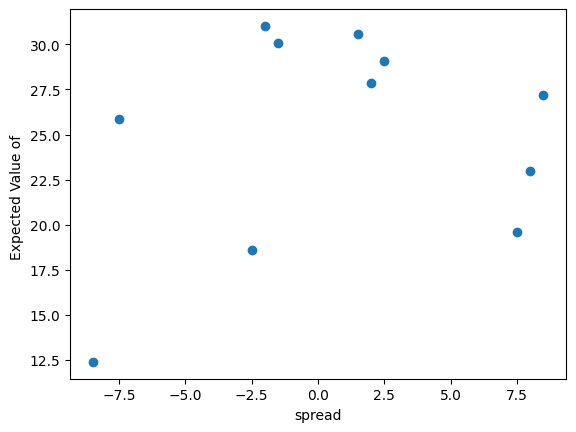

In [22]:
plt.scatter(x=grouped.index, y=grouped.EV)
plt.xlabel('spread')
plt.ylabel('Expected Value of ')
plt.show()

Okay so what we've discovered is that there is value to be made. Road underdogs are where the high value is at. Favorites & Home teams aren't actually profitable by themselves, but may be worth is as long as you don't combine them.

In [23]:
# What if we limit the dataset to just underdogs & away teams. What's the EV we can get?

total_cutoff = 48
line = (df.fav_tease_opp == 0)
field = (df.home_tease_opp == 0)
not_tie = (df.score_diff != 0)
under_total = (df.total_line <= total_cutoff)
away_dogs = df.loc[line & field & not_tie & under_total]
away_dogs

,game_id,game_type,weekday,score_diff,spread_line,total_line,teased_line,home_favorite,home_cover,home_win,home_tease_opp,fav_tease_opp,home_dog_cover_tease,away_fav_cover_tease,away_dog_cover_tease,home_fav_cover_tease,total_tease_covers
6501,2023_06_WAS_ATL,REG,Sunday,-8.0,1.5,42.0,7.5,1,0,0,0,0,0,0,1,0,1
6495,2023_05_NYJ_DEN,REG,Sunday,-10.0,2.5,42.5,8.5,1,0,0,0,0,0,0,1,0,1
6491,2023_05_NO_NE,REG,Sunday,-34.0,2.5,38.5,8.5,1,0,0,0,0,0,0,1,0,1
6487,2023_05_HOU_ATL,REG,Sunday,2.0,2.5,42.0,8.5,1,0,1,0,0,0,0,1,0,1
6444,2023_02_CHI_TB,REG,Sunday,10.0,2.5,41.0,8.5,1,1,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5100,2018_04_DET_DAL,REG,Sunday,2.0,2.5,44.0,8.5,1,0,1,0,0,0,0,1,0,1
5107,2018_04_CLE_OAK,REG,Sunday,3.0,2.5,44.5,8.5,1,1,1,0,0,0,0,1,0,1
5084,2018_03_CIN_CAR,REG,Sunday,10.0,2.5,44.0,8.5,1,1,1,0,0,0,0,0,0,0
5059,2018_01_WAS_ARI,REG,Sunday,-18.0,2.0,43.5,8.0,1,0,0,0,0,0,0,1,0,1


In [24]:
total_tease_opps = len(away_dogs)
total_tease_covers = len(away_dogs[away_dogs.total_tease_covers ==1])

In [25]:
# 2 team teaser

leg_number = 2
leg_hit_prob = total_tease_covers/total_tease_opps
teaser_hit_chance = leg_hit_prob ** leg_number
expected_value = teaser_hit_chance * (bet *two_team_teaser_win) - (1 - teaser_hit_chance) * bet

print(f"{leg_number} team teaser - All opportunties")
print(f"Leg hit chance: %{leg_hit_prob *100:.2f}")
print(f"Teaser hit chance: %{teaser_hit_chance *100:.2f}")
print(f"The expected value of a ${bet} bet: ${expected_value:.2f} profit")

2 team teaser - All opportunties
Leg hit chance: %82.28
Teaser hit chance: %67.70
The expected value of a $100 bet: $24.11 profit


Note taking on results: Under 48 <br>
Away + Dogs = 24.11 EV <br>
Home + Favs = -4.81 EV <br>
Away + Fav = 3.12 EV <br>
Home + Dogs = -1.41 EV 